<a href="https://colab.research.google.com/github/pvdklei/modelsmakemodels/blob/master/sebas/denoise_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import train
import utils

In [2]:
traintransform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testtransform = traintransform

batch_size = 32
num_workers = 2

trainset = datasets.CIFAR10("/data/cifar10/train", train=True, transform=traintransform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = datasets.CIFAR10("/data/cifar10/test", train=False, transform=testtransform, download=True)
testloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
imiter = iter(trainloader)
images, _ = next(imiter)
image = images[0]
images.shape


torch.Size([32, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


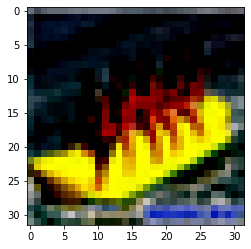

In [4]:
def showimage(image):
    image = image.detach().numpy()
    image = image.transpose((1, 2, 0))
    plt.imshow(image)
showimage(torchvision.utils.make_grid(images[0]))


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)

        self.conv1 = nn.Conv2d(3, 12, kernel_size=4, stride=2, padding = 1)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x
        
enc = Encoder()
enc(images).shape

torch.Size([32, 48, 4, 4])

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop = nn.Dropout(0.2)
        
        self.conv1 = nn.ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(12, 3, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

decoder = Decoder()
decoder(enc(images)).shape

torch.Size([32, 3, 32, 32])

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoenc = AutoEncoder()
autoenc(images).shape

torch.Size([32, 3, 32, 32])

In [8]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (drop): Dropout(p=0.2, inplace=False)
    (conv1): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [27]:
criterion = nn.MSELoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.001)
noise_factor=0.5
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(device)

lowest_testloss = np.Inf

for epoch in range(epochs):

    # training
    trainloss = 0
    for images, labels in trainloader:
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        images = images.to(device)
        noisy_imgs, labels = noisy_imgs.to(device), labels.to(device)
        ## add random noise to the input images

        optimizer.zero_grad()
        out = model(noisy_imgs)
        loss = criterion(out, images)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
    print(f"Epoch {epoch}, Training loss: {trainloss}")

    # validation
    testloss = 0
    for images, labels in testloader:
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        noisy_imgs = noisy_imgs.to(device)          
        images, labels = images.to(device), labels.to(device)
        ## add random noise to the input images
        with torch.no_grad():

            out = model(noisy_imgs)
            loss = criterion(out, images)
            testloss += loss
    print(f"Epoch {epoch}, Validation loss: {testloss}")
    lowest_testloss = testloss



cuda
Epoch 0, Training loss: 234.73477029055357
Epoch 0, Validation loss: 234.66812133789062
Epoch 1, Training loss: 234.62600667774677
Epoch 1, Validation loss: 234.60928344726562
Epoch 2, Training loss: 234.5856560021639
Epoch 2, Validation loss: 234.60446166992188
Epoch 3, Training loss: 234.57367624342442
Epoch 3, Validation loss: 234.56484985351562
Epoch 4, Training loss: 234.59567242115736
Epoch 4, Validation loss: 234.5760955810547
Epoch 5, Training loss: 234.55561847239733
Epoch 5, Validation loss: 234.5569305419922
Epoch 6, Training loss: 234.56597433239222
Epoch 6, Validation loss: 234.56304931640625
Epoch 7, Training loss: 234.5592384338379
Epoch 7, Validation loss: 234.5471649169922
Epoch 8, Training loss: 234.54153583198786
Epoch 8, Validation loss: 234.52801513671875
Epoch 9, Training loss: 234.53808915615082
Epoch 9, Validation loss: 234.56930541992188


In [28]:
torch.save(model.state_dict(), 'denoise.model')

In [29]:
state_dict = torch.load("denoise.model")
model.load_state_dict(state_dict)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


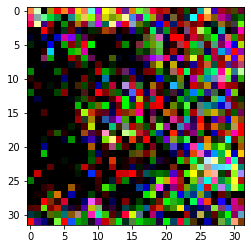

In [30]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)

# get sample outputs
cpumodel = model.cpu()
out = cpumodel(noisy_imgs)
showimage(torchvision.utils.make_grid(noisy_imgs[0]))

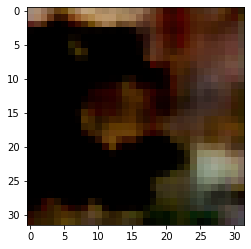

In [31]:
# output na denoising
showimage(torchvision.utils.make_grid(out[0]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


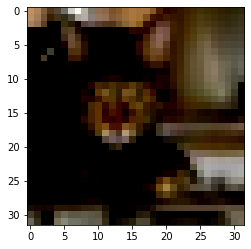

In [32]:
# originele image
showimage(torchvision.utils.make_grid(images[0]))
